# Step 2 - Objects & Pointing Vectors

In [1]:
#%matplotlib inline
%matplotlib widget

import os
import json
import gzip
import pickle
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import trimesh

from palettable.colorbrewer.qualitative import Set1_9, Dark2_5, Paired_6

from helpers import intersect, annotate_comparison

In [2]:
# Paths and constants
COND_COLORS = Set1_9.mpl_colors[0:3]
FB_COLORS = Dark2_5.mpl_colors[0:3]

FOLDER_DATA = '../stats'
FOLDER_FIG = '../figures'
FOLDER_OBJ = '../objects'
FOLDER_OUT = '../stats'

DROP_PPIDS = ['17'] # P17 has invalid data

# Number of random sampling points for each object
NUM_RANDOM_REF = 100


In [3]:
# Read pre-processed data
with open(os.path.join(FOLDER_DATA, 'all_sessions.pkl'), 'rb') as pf:
    sessions = pickle.load(pf)
with open(os.path.join(FOLDER_DATA, 'all_trials.pkl'), 'rb') as pf:
    trials = pickle.load(pf)

VALID_PPIDS = sessions.ppid.unique()
print(len(VALID_PPIDS))

24


## Load and Process Target Objects

In [4]:
# Load object meshes
OBJS = trials.loc[trials.type == 'obj'].object.unique()

def load_and_scale_mesh(filename, scale):
    """ Load .glb file and scale by scaling factor """
    m = trimesh.load(filename, force='mesh')
    matrix = np.eye(4)
    matrix[:3, :3] *= scale
    m.apply_transform(matrix)
    return m

obj = {}
for o in OBJS:
    mf = os.path.join(FOLDER_OBJ, o + '.glb')
    obj[o] = load_and_scale_mesh(mf, 0.6) # Objects were 0.6 m tall  
    
print(obj.keys())

dict_keys(['oben_asym', 'sphere', 'mitte_sym', 'mitte_asym', 'unten_sym', 'unten_asym', 'oben_sym'])


In [5]:
# Create rotated mesh versions for all viewpoints
ROTS = trials.loc[trials.type == 'obj'].obj_angle.unique()

def rotate_mesh_object(mesh, angle_deg):
    """ Return a mesh, rotated by specified angle """
    R = trimesh.transformations.euler_matrix(np.deg2rad(angle_deg), 0, 0, 'ryzx').T
    m = mesh.copy()
    m.apply_transform(R)
    return m

obj_rot = {}
for o in OBJS:
    obj_rot[o] = {}
    for r in ROTS:
        obj_rot[o][r] = rotate_mesh_object(obj[o], r)

print(ROTS)

[ 90. 215.   0. 135.]


In [6]:
# Calculate and define object properties
obj_data = {}
for o in obj.keys():
    rnd_points = trimesh.sample.volume_mesh(obj[o], NUM_RANDOM_REF)
    
    # Select random points from within bounding box as baseline model
    rnd_points = obj[o].bounding_box.sample_volume(NUM_RANDOM_REF)
    
    #print(o)
    #print(rnd_points)
    #print(obj[o].contains(rnd_points))
    
    obj_data[o] = {'mesh': obj[o],
                   'cog': obj[o].center_mass,
                   'centroid': obj[o].centroid,
                   'bbox_center': obj[o].bounding_box.centroid,
                   'random': rnd_points[:NUM_RANDOM_REF]}
    
# Add object fixed factors (easier than to extract them from trial files)
obj_data['unten_sym'].update({'symmetry': 'sym', 'vertical': 'low'})
obj_data['unten_asym'].update({'symmetry': 'asym', 'vertical': 'low'})
obj_data['mitte_sym'].update({'symmetry': 'sym', 'vertical': 'middle'})
obj_data['mitte_asym'].update({'symmetry': 'asym', 'vertical': 'middle'})
obj_data['oben_sym'].update({'symmetry': 'sym', 'vertical': 'high'})
obj_data['oben_asym'].update({'symmetry': 'asym', 'vertical': 'high'})
obj_data['sphere'].update({'symmetry': 'sym', 'vertical': 'middle'})

# Export table of object data
objtbl = []
for o in obj_data.keys():
    w = obj_data[o]['mesh'].extents.round(4)
    c = obj_data[o]['cog'].round(4)
    cc = obj_data[o]['centroid'].round(4)
    b = obj_data[o]['bbox_center'].round(4)
    objtbl.append({'object': o,
                   'width': w[0],
                   'height': w[1],
                   'depth': w[2],
                   'cog_x': c[0],
                   'cog_y': c[1],
                   'cog_z': c[2],                   
                   'centroid_x': cc[0],
                   'centroid_y': cc[1],
                   'centroid_z': cc[2],
                   'bbox_x': b[0],
                   'bbox_y': b[1],
                   'bbox_z': b[2]})

objtbl = pd.DataFrame(objtbl, columns=list(objtbl[0].keys())).sort_values(['object'])
objtbl.to_csv(os.path.join(FOLDER_DATA, 'table_objects.tsv'), sep='\t', index=False)


## Table: Object Properties

In [7]:
# Table 1 - object size and properties
objtbl.sort_values('cog_y', ascending=False).round(2)

,object,width,height,depth,cog_x,cog_y,cog_z,centroid_x,centroid_y,centroid_z,bbox_x,bbox_y,bbox_z
0,oben_asym,0.53,0.6,0.60,0.01,0.34,-0.0,0.01,0.34,-0.0,0.03,0.29,-0.0
6,oben_sym,0.55,0.6,0.55,0.00,0.34,-0.0,0.00,0.34,-0.0,0.00,0.29,-0.0
3,mitte_asym,0.60,0.6,0.60,-0.05,0.31,0.0,-0.05,0.31,-0.0,-0.06,0.29,-0.0
2,mitte_sym,0.60,0.6,0.60,-0.00,0.31,-0.0,-0.00,0.31,-0.0,-0.00,0.29,-0.0
1,sphere,0.60,0.6,0.60,0.00,0.30,0.0,0.00,0.30,0.0,0.00,0.30,0.0
4,unten_sym,0.60,0.6,0.60,-0.00,0.21,-0.0,-0.00,0.21,-0.0,-0.00,0.29,-0.0
5,unten_asym,0.60,0.6,0.60,0.06,0.21,-0.0,0.07,0.21,-0.0,0.09,0.29,0.0


In [8]:
# Plot an object's random sample locations
def plot_object_random_coords(obj_data, obj):
    mesh = obj_data[obj]['mesh']

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(mesh.vertices[:, 0], -mesh.vertices[:, 2], triangles=mesh.faces, 
                    Z=mesh.vertices[:,1], color='gray', alpha=0.5) 
    
    for p in obj_data[obj]['random']:
        if obj_data[obj]['mesh'].contains(p.reshape((1, 3))):
            ax.scatter(p[0], p[1], p[2],  zdir='y',  color='g')
        else:
            ax.scatter(p[0], p[1], p[2],  zdir='y',  color='r')
            
    ax.set_xlabel('X (m)')    
    ax.set_ylabel('Z (m)')
    ax.set_zlabel('Y (m)')

# Plot an object with its random bbox coordinates
# Note that vase meshes are "double-walled", so "contains" does not work as expected

#plot_object_random_coords(obj_data, 'unten_asym')

## Compute 3D Endpoints

In [9]:
# Calculate by-subject by-object 3d endpoints
# Note: Using LEFT eye EFRC due to baseline results!

models = []
endpoints = []
for idx, s in sessions.iterrows():
    for iobj in ['oben_asym', 'mitte_sym', 'mitte_asym', 'unten_sym', 'unten_asym', 'oben_sym', 'sphere']:
        t = trials.loc[(trials.ppid == s.ppid) & (trials.session == s.session) & (trials.object == iobj),:]

        for eye in ['', 'L', 'R', 'D']:

            P0e = []
            P1e = []
            P0g_first = []
            P1g_first = []
            P0g_final = []
            P1g_final = []
            for rot in trials.obj_angle.unique():
                for h in trials.table_height.unique():
                    if t.loc[(t.obj_angle == rot) & (t.table_height == h), :].shape[0] < 1:
                        continue

                    # Average EFRC hand raycast for this object x viewpoint
                    eX = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'efrc{:s}_posX_rot'.format(eye)])
                    eY = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'efrc{:s}_posY_rot'.format(eye)])
                    eZ = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'efrc{:s}_posZ_rot'.format(eye)])
                    edX = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'efrc{:s}_vecX_rot'.format(eye)])
                    edY = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'efrc{:s}_vecY_rot'.format(eye)])
                    edZ = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'efrc{:s}_vecZ_rot'.format(eye)])

                    P0e.append([eX, eY, eZ])
                    P1e.append([edX + eX, edY + eY, edZ + eZ])

                    # Average gaze raycast for this object x viewpoint - FIRST gaze 
                    g1X = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'first_gaze3d_posX_rot'])
                    g1Y = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'first_gaze3d_posY_rot'])
                    g1Z = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'first_gaze3d_posZ_rot'])
                    g1dX = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'first_gaze3d_vecX_rot'])
                    g1dY = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'first_gaze3d_vecY_rot'])
                    g1dZ = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'first_gaze3d_vecZ_rot'])

                    P0g_first.append([g1X, g1Y, g1Z])
                    P1g_first.append([g1dX + g1X, g1dY + g1Y, g1dZ + g1Z])

                    # Average gaze raycast for this object x viewpoint - FINAL gaze 
                    g2X = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'final_gaze3d_posX_rot'])
                    g2Y = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'final_gaze3d_posY_rot'])
                    g2Z = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'final_gaze3d_posZ_rot'])
                    g2dX = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'final_gaze3d_vecX_rot'])
                    g2dY = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'final_gaze3d_vecY_rot'])
                    g2dZ = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'final_gaze3d_vecZ_rot'])

                    P0g_final.append([g2X, g2Y, g2Z])
                    P1g_final.append([g2dX + g2X, g2dY + g2Y, g2dZ + g2Z])

            # Closest ray correspondence
            P0e = np.array(P0e)
            P1e = np.array(P1e)
            P0g_first = np.array(P0g_first)
            P1g_first = np.array(P1g_first)
            P0g_final = np.array(P0g_final)
            P1g_final = np.array(P1g_final)

            if np.any(np.isnan(P0e)):
                efrc_closest = [[np.nan,],] * 3
            else:
                efrc_closest = intersect(P0e, P1e)    

            if np.any(np.isnan(P0g_first)):
                gaze_first_closest = [[np.nan,],] * 3
            else:
                gaze_first_closest = intersect(P0g_first, P1g_first)    
                
            if np.any(np.isnan(P0g_final)):
                gaze_final_closest = [[np.nan,],] * 3
            else:
                gaze_final_closest = intersect(P0g_final, P1g_final)    
            
            # Distance to center measures - pointing ray
            err_cog = [np.abs(obj_data[iobj]['cog'][0] - efrc_closest[0][0]), 
                       np.abs(obj_data[iobj]['cog'][1] - efrc_closest[1][0]),
                       np.abs(obj_data[iobj]['cog'][2] - efrc_closest[2][0])]
            err_cog_abs = np.linalg.norm(np.array(err_cog), ord=2)

            err_bbox = [np.abs(obj_data[iobj]['bbox_center'][0] - efrc_closest[0][0]), 
                        np.abs(obj_data[iobj]['bbox_center'][1] - efrc_closest[1][0]),
                        np.abs(obj_data[iobj]['bbox_center'][2] - efrc_closest[2][0])]
            err_bbox_abs = np.linalg.norm(np.array(err_bbox), ord=2)

            err_cent = [np.abs(obj_data[iobj]['centroid'][0] - efrc_closest[0][0]), 
                       np.abs(obj_data[iobj]['centroid'][1] - efrc_closest[1][0]),
                       np.abs(obj_data[iobj]['centroid'][2] - efrc_closest[2][0])]
            err_cent_abs = np.linalg.norm(np.array(err_cent), ord=2)

            
            # Distance to center measures - gaze rays
            first_err_cog = [np.abs(obj_data[iobj]['cog'][0] - gaze_first_closest[0][0]), 
                             np.abs(obj_data[iobj]['cog'][1] - gaze_first_closest[1][0]),
                             np.abs(obj_data[iobj]['cog'][2] - gaze_first_closest[2][0])]
            first_err_cog_abs = np.linalg.norm(np.array(first_err_cog), ord=2)
            final_err_cog = [np.abs(obj_data[iobj]['cog'][0] - gaze_final_closest[0][0]), 
                             np.abs(obj_data[iobj]['cog'][1] - gaze_final_closest[1][0]),
                             np.abs(obj_data[iobj]['cog'][2] - gaze_final_closest[2][0])]
            final_err_cog_abs = np.linalg.norm(np.array(final_err_cog), ord=2)
            
            first_err_bbox = [np.abs(obj_data[iobj]['bbox_center'][0] - gaze_first_closest[0][0]), 
                             np.abs(obj_data[iobj]['bbox_center'][1] - gaze_first_closest[1][0]),
                             np.abs(obj_data[iobj]['bbox_center'][2] - gaze_first_closest[2][0])]
            first_err_bbox_abs = np.linalg.norm(np.array(first_err_bbox), ord=2)
            final_err_bbox = [np.abs(obj_data[iobj]['bbox_center'][0] - gaze_final_closest[0][0]), 
                             np.abs(obj_data[iobj]['bbox_center'][1] - gaze_final_closest[1][0]),
                             np.abs(obj_data[iobj]['bbox_center'][2] - gaze_final_closest[2][0])]
            final_err_bbox_abs = np.linalg.norm(np.array(final_err_bbox), ord=2)

            
            # Average distance from baseline random points
            err_random_x = []
            err_random_y = []
            err_random_z = []
            err_random_abs = []
            
            first_err_random_x = []
            first_err_random_y = []
            first_err_random_z = []
            first_err_random_abs = []
            
            final_err_random_x = []
            final_err_random_y = []
            final_err_random_z = []
            final_err_random_abs = []
            
            # EFRC
            for p in obj_data[iobj]['random']:
                err_random_x.append(np.abs(p[0] - efrc_closest[0][0]))
                err_random_y.append(np.abs(p[1] - efrc_closest[1][0]))
                err_random_z.append(np.abs(p[2] - efrc_closest[2][0]))
                err_random_abs.append(np.linalg.norm(np.array([p[0] - efrc_closest[0][0], p[1] - efrc_closest[1][0], p[2] - efrc_closest[2][0]]), ord=2))

                first_err_random_x.append(np.abs(p[0] - gaze_first_closest[0][0]))
                first_err_random_y.append(np.abs(p[1] - gaze_first_closest[1][0]))
                first_err_random_z.append(np.abs(p[2] - gaze_first_closest[2][0]))
                first_err_random_abs.append(np.linalg.norm(np.array([p[0] - gaze_first_closest[0][0], p[1] - gaze_first_closest[1][0], p[2] - gaze_first_closest[2][0]]), ord=2))

                final_err_random_x.append(np.abs(p[0] - gaze_final_closest[0][0]))
                final_err_random_y.append(np.abs(p[1] - gaze_final_closest[1][0]))
                final_err_random_z.append(np.abs(p[2] - gaze_final_closest[2][0]))
                final_err_random_abs.append(np.linalg.norm(np.array([p[0] - gaze_final_closest[0][0], p[1] - gaze_final_closest[1][0], p[2] - gaze_final_closest[2][0]]), ord=2))

            if eye == '':
                eye_label = 'B'                
            else:
                eye_label = eye
            
            # Endpoints
            m = {'ppid': s.ppid, 'session': s.session, 'object': iobj,
                 'feedback': s.feedback, 'eye': eye_label,
                 'vertical': obj_data[iobj]['vertical'], 'symmetry': obj_data[iobj]['symmetry'],
                 'efrc3d_X': efrc_closest[0][0], 'efrc3d_Y': efrc_closest[1][0], 'efrc3d_Z': efrc_closest[2][0],
                 'first_gaze3d_X': gaze_first_closest[0][0], 'first_gaze3d_Y': gaze_first_closest[1][0], 'first_gaze3d_Z': gaze_first_closest[2][0],
                 'final_gaze3d_X': gaze_final_closest[0][0], 'final_gaze3d_Y': gaze_final_closest[1][0], 'final_gaze3d_Z': gaze_final_closest[2][0]
                }
            endpoints.append(m)

            # Error: CoM
            o = {'ppid': s.ppid, 'session': s.session, 'object': iobj,
                 'feedback': s.feedback, 'eye': eye_label,
                 'vertical': obj_data[iobj]['vertical'], 'symmetry': obj_data[iobj]['symmetry'],
                 'model': 'cog',
                 'efrc_errX': err_cog[0], 'efrc_errY': err_cog[1], 'efrc_errZ': err_cog[2], 'efrc_err': err_cog_abs,
                 'first_gaze_errX': first_err_cog[0], 'first_gaze_errY': first_err_cog[1], 'first_gaze_errZ': first_err_cog[2], 'first_gaze_err': first_err_cog_abs,
                 'final_gaze_errX': final_err_cog[0], 'final_gaze_errY': final_err_cog[1], 'final_gaze_errZ': final_err_cog[2], 'final_gaze_err': final_err_cog_abs
                }
            models.append(o)

            # Error: BBox
            o = {'ppid': s.ppid, 'session': s.session, 'object': iobj,
                 'feedback': s.feedback, 'eye': eye_label,
                 'vertical': obj_data[iobj]['vertical'], 'symmetry': obj_data[iobj]['symmetry'],
                 'model': 'bbox',
                 'efrc_errX': err_bbox[0], 'efrc_errY': err_bbox[1], 'efrc_errZ': err_bbox[2], 'efrc_err': err_bbox_abs,
                 'first_gaze_errX': first_err_bbox[0], 'first_gaze_errY': first_err_bbox[1], 'first_gaze_errZ': first_err_bbox[2], 'first_gaze_err': first_err_bbox_abs,
                 'final_gaze_errX': final_err_bbox[0], 'final_gaze_errY': final_err_bbox[1], 'final_gaze_errZ': final_err_bbox[2], 'final_gaze_err': final_err_bbox_abs               
                }
            models.append(o)

            # Error: Random
            o = {'ppid': s.ppid, 'session': s.session, 'object': iobj,
                 'feedback': s.feedback, 'eye': eye_label,
                 'vertical': obj_data[iobj]['vertical'], 'symmetry': obj_data[iobj]['symmetry'],
                 'model': 'random',
                 'efrc_errX': np.mean(err_random_x), 'efrc_errY': np.mean(err_random_y), 'efrc_errZ': np.mean(err_random_z), 'efrc_err': np.mean(err_random_abs),
                 'first_gaze_errX': np.mean(first_err_random_x), 'first_gaze_errY': np.mean(first_err_random_y), 'first_gaze_errZ': np.mean(first_err_random_z), 'first_gaze_err': np.mean(first_err_random_abs),
                 'final_gaze_errX': np.mean(final_err_random_x), 'final_gaze_errY': np.mean(final_err_random_y), 'final_gaze_errZ': np.mean(final_err_random_z), 'final_gaze_err': np.mean(final_err_random_abs)                 
                }
            models.append(o)

            #o = {'ppid': s.ppid, 'session': s.session, 'object': iobj,
            #     'feedback': s.feedback, 
            #     'vertical': obj_data[iobj]['vertical'], 'symmetry': obj_data[iobj]['symmetry'],
            #     'model': 'centroid',
            #     'efrc_errX': err_cent[0], 'efrc_errY': err_cent[1], 'efrc_errZ': err_cent[2], 'efrc_err': err_cent_abs,
            #    }
            #models.append(o)

aggdata = pd.DataFrame(models, columns=list(models[0].keys()))
print(aggdata.shape)

endpoints = pd.DataFrame(endpoints, columns=list(endpoints[0].keys()))
print(endpoints.shape) # N=24 * 6 objects * 3 feedbacks

C:\Users\Immo\AppData\Local\Temp\ipykernel_15080\3894756002.py:26: RuntimeWarning: Mean of empty slice
  eZ = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'efrc{:s}_posZ_rot'.format(eye)])
C:\Users\Immo\AppData\Local\Temp\ipykernel_15080\3894756002.py:24: RuntimeWarning: Mean of empty slice
  eX = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'efrc{:s}_posX_rot'.format(eye)])
C:\Users\Immo\AppData\Local\Temp\ipykernel_15080\3894756002.py:25: RuntimeWarning: Mean of empty slice
  eY = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'efrc{:s}_posY_rot'.format(eye)])
C:\Users\Immo\AppData\Local\Temp\ipykernel_15080\3894756002.py:46: RuntimeWarning: Mean of empty slice
  g2X = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'final_gaze3d_posX_rot'])
C:\Users\Immo\AppData\Local\Temp\ipykernel_15080\3894756002.py:48: RuntimeWarning: Mean of empty slice
  g2Z = np.nanmean(t.loc[(t.obj_angle == rot) & (t.table_height == h), 'fina

(6048, 20)
(2016, 16)


In [10]:
# Outdated, not considering eye 
#n_no_endpoint = aggdata.loc[np.isnan(aggdata.efrc_err), :].shape[0] 
#print('{:d} / {:d} ({:.2f}%) without valid EFRC endpoint'.format(n_no_endpoint, aggdata.shape[0], (n_no_endpoint/aggdata.shape[0] * 100)))


In [11]:
# % invalid trials per eye vector origin
display(endpoints.groupby('eye').count().loc[:, 'ppid'])
display(endpoints.loc[(np.isnan(endpoints.efrc3d_X)) | (np.isnan(endpoints.efrc3d_Y)) | (np.isnan(endpoints.efrc3d_Z)), :].groupby('eye').count().loc[:, 'ppid'])
display(endpoints.loc[(np.isnan(endpoints.efrc3d_X)) | (np.isnan(endpoints.efrc3d_Y)) | (np.isnan(endpoints.efrc3d_Z)), :].groupby('eye').count().loc[:, 'ppid'] / endpoints.groupby('eye').count().loc[:, 'ppid'] * 100)


eye
B    504
D    504
L    504
R    504
Name: ppid, dtype: int64

eye
B    46
D    53
L    42
R    55
Name: ppid, dtype: int64

eye
B     9.126984
D    10.515873
L     8.333333
R    10.912698
Name: ppid, dtype: float64

In [12]:
# % invalid trials per eye vector origin
display(endpoints.loc[endpoints.eye == 'B', 'ppid'].shape[0])
display(endpoints.loc[(np.isnan(endpoints.final_gaze3d_X)) | (np.isnan(endpoints.final_gaze3d_Y)) | (np.isnan(endpoints.final_gaze3d_Z)), :].groupby('eye').count().loc[:, 'ppid'])
display(endpoints.loc[(np.isnan(endpoints.final_gaze3d_X)) | (np.isnan(endpoints.final_gaze3d_Y)) | (np.isnan(endpoints.final_gaze3d_Z)), :].groupby('eye').count().loc[:, 'ppid'] / endpoints.groupby('eye').count().loc[:, 'ppid'] * 100)


504

eye
B    5
D    5
L    5
R    5
Name: ppid, dtype: int64

eye
B    0.992063
D    0.992063
L    0.992063
R    0.992063
Name: ppid, dtype: float64

## Plot: 3D Endpoint Methods Example

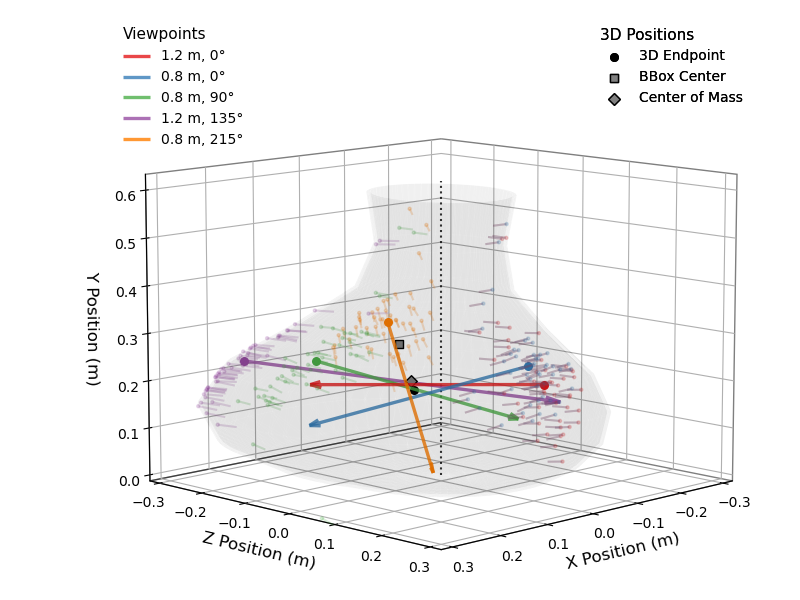

In [13]:
def plot_object_data_vectors(trials, obj_dict, obj, angle=0, plot_samples=True, plot_rays=False, alpha=0.4, mesh_alpha=0.03,
                             plot_mesh=True, plot_efrc=True, limits=0.31):
    """ Plot a 3d point dataset with averages and object centers """
    
    COLORS = Set1_9.mpl_colors
    INDIV_ALPHA = 0.2
    
    if type(trials) not in (list, tuple):
        trials = [trials,]
    
    fig = plt.figure(figsize=(8,6), facecolor='none')
    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('none')

    # Show the mesh
    mesh = obj_dict[obj]['mesh'].smooth_shaded
    if plot_mesh:
        ax.plot_trisurf(mesh.vertices[:, 0], -mesh.vertices[:,2], triangles=mesh.faces, 
                        Z=mesh.vertices[:,1], color=(0, 0, 0, 0.1), alpha=mesh_alpha)

    # Legend entries
    view_h = []
    view_l = []
    point_h = []
    point_l = []

    for trial_set in trials:
        d = trial_set.loc[trial_set.object == obj, :].copy()

        # Individual data samples
        P0g = []
        P1g = []
        P0e = []
        P1e = []
        c = 0        
        for rot in [0, 90, 135, 215]:
            for h in [1.2, 0.8]:
                if d.loc[(d.obj_angle == rot) & (d.table_height == h), :].shape[0] < 1:
                    continue
            
                if plot_efrc:
                    if plot_samples:
                        ax.scatter(d.loc[(d.obj_angle == rot) & (d.table_height == h), 'efrcL_posX_rot'],
                                   d.loc[(d.obj_angle == rot) & (d.table_height == h), 'efrcL_posY_rot'],
                                   -d.loc[(d.obj_angle == rot) & (d.table_height == h), 'efrcL_posZ_rot'], 
                                   marker='o', s=5, color=COLORS[c], alpha=INDIV_ALPHA, zdir='y')

                    if plot_rays:
                        ax.quiver(d.loc[d.obj_angle == rot, 'efrcL_posX_rot'], 
                                  -d.loc[d.obj_angle == rot, 'efrcL_posZ_rot'], 
                                  d.loc[d.obj_angle == rot, 'efrcL_posY_rot'],
                                  d.loc[d.obj_angle == rot, 'efrcL_vecX_rot'], 
                                  -d.loc[d.obj_angle == rot, 'efrcL_vecZ_rot'], 
                                  d.loc[d.obj_angle == rot, 'efrcL_vecY_rot'],
                                  color=COLORS[c], alpha=INDIV_ALPHA, length=0.03,
                                  arrow_length_ratio=0.001)

                    eX = np.nanmean(d.loc[(d.obj_angle == rot) & (d.table_height == h), 'efrcL_posX_rot'])
                    eY = np.nanmean(d.loc[(d.obj_angle == rot) & (d.table_height == h), 'efrcL_posY_rot'])
                    eZ = np.nanmean(d.loc[(d.obj_angle == rot) & (d.table_height == h), 'efrcL_posZ_rot'])
                    ax.scatter(eX, eY, -eZ, marker='o', color=COLORS[c], zdir='y', s=30)

                    edX = np.nanmean(d.loc[(d.obj_angle == rot) & (d.table_height == h), 'efrcL_vecX_rot'])
                    edY = np.nanmean(d.loc[(d.obj_angle == rot) & (d.table_height == h), 'efrcL_vecY_rot'])
                    edZ = np.nanmean(d.loc[(d.obj_angle == rot) & (d.table_height == h), 'efrcL_vecZ_rot'])
                    handle = ax.quiver(eX, -eZ, eY, edX, -edZ, edY, color=COLORS[c], length=0.5, 
                              linestyle='-', arrow_length_ratio=0.05, alpha=0.8, linewidth=2.4)
                    view_h.append(handle)
                    view_l.append('{:.1f} m, {:.0f}°'.format(h, rot))

                    P0e.append([eX, eY, eZ])
                    P1e.append([edX + eX, edY + eY, edZ + eZ])
            
                c += 1

        # EFRC point of correspondence
        if plot_efrc:
            P0e = np.array(P0e)
            P1e = np.array(P1e)
            efrc_closest = intersect(P0e, P1e)
            ph = ax.scatter(efrc_closest[0], efrc_closest[1], -efrc_closest[2], marker='o', 
                       color='k', zdir='y', s=30, zorder=20)
            point_h.append(ph)
            point_l.append('3D Endpoint')

    
    # Origin
    #ax.scatter(0, 0, 0, marker='o', color='k')
    
    # Symmetry axis
    ax.plot([0.0, 0.0], [0.0, limits*2], [0.0, 0.0], 'k:',alpha=0.8, linewidth=1.5, zdir='y')

    # Object center measures
    cog = mesh.center_mass
    centroid = mesh.centroid
    bboxc = mesh.bounding_box.centroid
    cog_h = ax.scatter(cog[0], cog[2], cog[1], marker='D', edgecolor='k', facecolor='gray', s=35, zorder=11)
    
    #ax.scatter(centroid[0], centroid[2], centroid[1], marker='+', color='yellow')
    bbox_h = ax.scatter(bboxc[0], bboxc[2], bboxc[1], marker='s', edgecolor='k', facecolor='gray', s=35, zorder=11)

    point_h.append(bbox_h)
    point_l.append('BBox Center')
    point_h.append(cog_h)
    point_l.append('Center of Mass')

    ax.set_xlabel('X Position (m)', fontsize=12, labelpad=2)
    ax.set_ylabel('Z Position (m)', fontsize=12, labelpad=2)
    ax.set_zlabel('Y Position (m)', fontsize=12, labelpad=2)
    ax.tick_params(pad=0.5)

    ax.set_xlim3d([-limits, limits])
    ax.set_ylim3d([-limits, limits])
    ax.set_zlim3d([0, limits*2])
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('k')
    ax.yaxis.pane.set_edgecolor('k')
    ax.zaxis.pane.set_edgecolor('k')

    azim = {0: 45}
    ax.view_init(elev=10, azim=azim[angle])
    viewleg = plt.legend(view_h, view_l, title='Viewpoints', loc='upper left', frameon=False, alignment='left', fontsize=10, title_fontsize=11)
    pointleg = plt.legend(point_h, point_l, loc='upper right', title='3D Positions', frameon=False, alignment='left', fontsize=10, title_fontsize=11)
    ax.add_artist(viewleg)
    ax.add_artist(pointleg)
    
    plt.tight_layout()
    fig.subplots_adjust(left=0.1, bottom=-0.1)  # plot outside the normal area
    

plot_object_data_vectors(trials.loc[trials.feedback == 'cursor', :], obj_data, 'unten_asym', plot_rays=True)
plt.savefig(os.path.join(FOLDER_FIG, 'example_vectors.png'), dpi=300)
plt.savefig(os.path.join(FOLDER_FIG, 'example_vectors.pdf'), dpi=300)

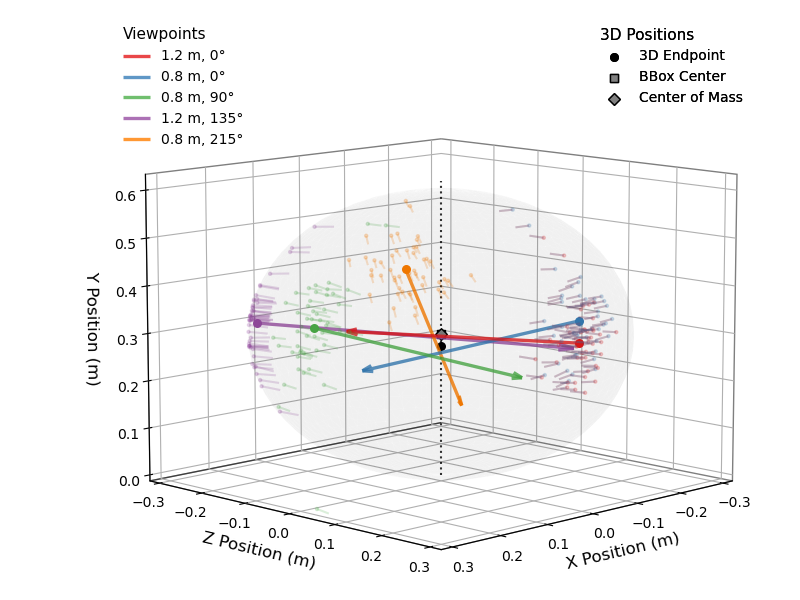

In [14]:
# Control Sphere
plot_object_data_vectors(trials.loc[trials.feedback == 'cursor', :], obj_data, 'sphere', plot_rays=True)


## Plot: Endpoint Errors vs. Models

C:\Users\Immo\AppData\Local\Temp\ipykernel_15080\1927814961.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(tr.loc[:, error_var]),
C:\Users\Immo\AppData\Local\Temp\ipykernel_15080\1927814961.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(tr.loc[:, error_var]),
C:\Users\Immo\AppData\Local\Temp\ipykernel_15080\1927814961.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(tr.loc[:, error_var]),


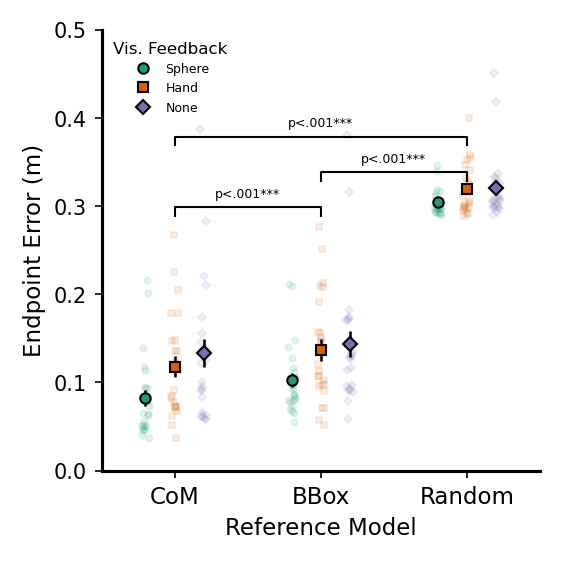

In [15]:
# Plot: Endpoint Errors by Model x Feedback
SMALL_MARKER_ALPHA = 0.1
SMALL_MARKER_SIZE = 3
AVG_MARKER_ALPHA = 1
AVG_MARKER_SIZE = 5
LABEL_SIZE=11

def plot_pointing_error_models(aggdata, figsize=(3.75, 3.75), xlimits=(-1.5, 1.5), ylimits=None, dodge=0.05, metric_dodge=0.2, error_var='efrc_err'):
    """ Plot endpoint errors to different models """
    
    MODELS = ['cog', 'bbox', 'random']
    FB_MARKERS = {'cursor': 'o', 
                  'hand': 's', 
                  'none': 'D'}
    MODELS_LABELS = {'cog': 'Center of Mass', 
                      'bbox': 'Bounding Box', 
                      'random': 'Random'}

    FEEDBACKS = ['cursor', 'hand', 'none']
    FEEDBACK_LABELS = ['Sphere', 'Hand', 'None']
    
    handles = []
    labels = []
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=150, 
                           subplot_kw={'facecolor': 'none'})
    
    
    for mix, metric in enumerate(MODELS): # models on x axis
        for ix, fb in enumerate(FEEDBACKS): # feedbacks dodged
        
            fb_x = np.linspace(-metric_dodge, +metric_dodge, len(FEEDBACKS))
            
            # By-Participant Data
            for ppid in VALID_PPIDS:
                tr = aggdata.loc[(aggdata.ppid == ppid) & (aggdata.feedback == fb) & (aggdata.model == metric), :]

                # Average calibration error per ppid, feedback and target
                ax.plot(mix + 1 + fb_x[ix] + (dodge * (np.random.random() - 0.5)), 
                        np.nanmean(tr.loc[:, error_var]),
                        marker=FB_MARKERS[fb], 
                        markersize=SMALL_MARKER_SIZE, 
                        color=FB_COLORS[ix], alpha=SMALL_MARKER_ALPHA)

            # Across-participant + target average + SEM
            all_err = aggdata.loc[(aggdata.feedback == fb) & (aggdata.model == metric), ['ppid', error_var]] \
                             .groupby(['ppid'], as_index=False) \
                             .agg('mean') \
                             .loc[:, error_var] 
            
            N = aggdata.loc[(aggdata.feedback == fb) & (aggdata.model == metric), 'ppid'].unique().shape[0]
            m = np.nanmean(all_err)
            sem = np.nanstd(all_err) / np.sqrt(N)
            
            h = ax.errorbar(x=mix+1 + fb_x[ix], 
                            y=m,
                            yerr=sem, 
                            marker=FB_MARKERS[fb], 
                            markersize=AVG_MARKER_SIZE, 
                            alpha=AVG_MARKER_ALPHA, 
                            color=FB_COLORS[ix], 
                            markeredgecolor='k',
                            ecolor='k',
                            linewidth=1.2)

            if mix == 0:
                handles.append(Line2D([0], [0], marker=FB_MARKERS[fb], color='k', ls='none', markerfacecolor=FB_COLORS[ix], markersize=AVG_MARKER_SIZE))
                labels.append(FEEDBACK_LABELS[ix])

    ax.set_xlim([0.5, 3.5])
    if ylimits is None:
        ax.set_ylim([0, 0.5])
    else:
        ax.set_ylim(ylimits)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['CoM', 'BBox', 'Random'], fontsize=LABEL_SIZE)
    ax.set_ylabel('Endpoint Error (m)', fontsize=LABEL_SIZE)
    ax.set_xlabel('Reference Model', fontsize=LABEL_SIZE)
    ax.legend(handles, labels, loc='upper left', frameon=False, fontsize=6, title='Vis. Feedback')
    
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.5)
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0)

    
    plt.tight_layout()

plot_pointing_error_models(aggdata, error_var='efrc_err')

plt.setp(plt.gca().get_legend().get_title(), fontsize=8)

# Overall main effect
annotate_comparison(plt.gca(), 1, 3, 0.39, "p<.001***", linewidth=1.0, fontsize=6, height=0.01, color='k')
annotate_comparison(plt.gca(), 2, 3, 0.35, "p<.001***", linewidth=1.0, fontsize=6, height=0.01, color='k')
annotate_comparison(plt.gca(), 1, 2, 0.31, "p<.001***", linewidth=1.0, fontsize=6, height=0.01, color='k')

# CoM comparison
#annotate_comparison(plt.gca(), 1 - 0.2, 2 - 0.2, 0.32, "p=.001**", linewidth=1.0, fontsize=6, height=0.01, color=FB_COLORS[0]) # Cursor: CoM vs Bbox
#annotate_comparison(plt.gca(), 2 - 0.2, 3 - 0.2, 0.36, "p<.001***", linewidth=1.0, fontsize=6, height=0.01,color=FB_COLORS[0]) # Cursor: CoM vs Random
#annotate_comparison(plt.gca(), 1 - 0.2, 3 - 0.2, 0.40, "p<.001***", linewidth=1.0, fontsize=6, height=0.01,color=FB_COLORS[0]) # Cursor: CoM vs Random

# Hand comparison
#annotate_comparison(plt.gca(), 1, 2, 0.12, "p=.001**", linewidth=1.0, fontsize=6, height=0.01, color=FB_COLORS[1]) # Hand: CoM vs Bbox
#annotate_comparison(plt.gca(), 2, 3, 0.16, "p<.001***", linewidth=1.0, fontsize=6, height=0.01,color=FB_COLORS[1]) # Hand: CoM vs Random
#annotate_comparison(plt.gca(), 1, 3, 0.26, "p<.001***", linewidth=1.0, fontsize=6, height=0.01,color=FB_COLORS[1]) # Hand: CoM vs Random


plt.savefig(os.path.join(FOLDER_FIG, 'pointing_error_models.png'), dpi=300)
plt.savefig(os.path.join(FOLDER_FIG, 'pointing_error_models.pdf'), dpi=300)

In [16]:
# First gaze point
#plot_pointing_error_models(aggdata, error_var='first_gaze_err', ylimits=[0, 1])

# Final gaze point
#plot_pointing_error_models(aggdata, error_var='final_gaze_err')

In [17]:
# Add separate columns for feedback methods, for easier split LMM analysis
for fb in ['cursor', 'hand', 'none']:
     aggdata.loc[aggdata.loc[:, 'feedback'] == fb, 'efrc_err_{:s}'.format(fb)] = aggdata.loc[aggdata.loc[:, 'feedback'] == fb, 'efrc_err']

for mod in ['cog', 'bbox', 'random']:
     aggdata.loc[aggdata.loc[:, 'model'] == mod, 'efrc_err_{:s}'.format(mod)] = aggdata.loc[aggdata.loc[:, 'model'] == mod, 'efrc_err']

# Save endpoint error data for LMM - LEFT eye data only
aggdata.loc[aggdata.eye == 'L', :].to_csv(os.path.join(FOLDER_OUT, 'lmm_endpoint_errors.csv'), sep='\t', index=False)

## Plot: Endpoints and emmeans

In [18]:
# Save selected endpoint error data for LMM analysis - CURSOR and LEFT eye only
avgdata = endpoints.loc[(endpoints.feedback == 'cursor') & (endpoints.eye == 'L') & (endpoints.object != 'sphere'), :]
avgdata.to_csv(os.path.join(FOLDER_OUT, 'lmm_com_symmetry.csv'), sep='\t', index=False)

In [19]:
# emmeans - X and Y coordinate for EFRC (from Jamovi)
COG_LABELS = ['high', 'middle', 'low']
emmeans_x = {'asymmetric': {'mean': [0.01054, 0.03221, 0.05408], 'sem': [0.00466, 0.00475, 0.00466]},
             'symmetric':  {'mean': [0.00462, -0.00099, 0.00075], 'sem': [0.00466, 0.00466, 0.00466]}}

emmeans_y = {'asymmetric': {'mean': [0.358, 0.290, 0.188], 'sem': [0.0181, 0.0183, 0.0181]},
             'symmetric':  {'mean': [0.350, 0.285, 0.192], 'sem': [0.0181, 0.0181, 0.0181]}}


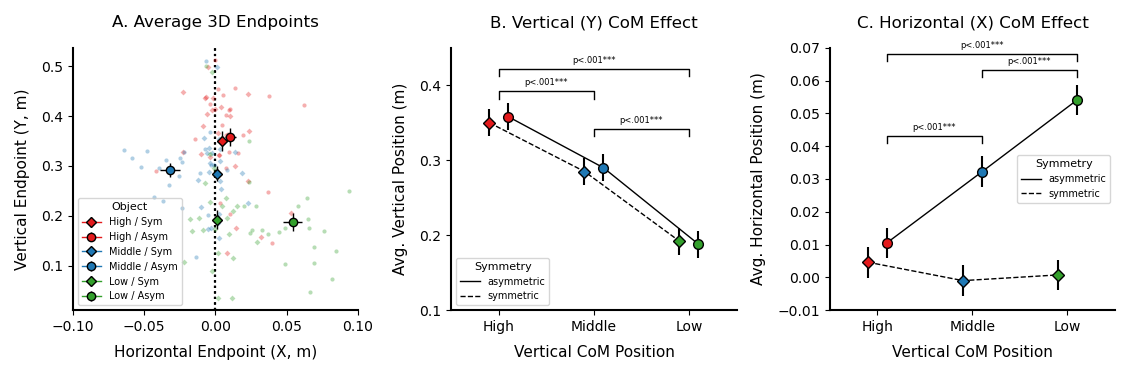

In [20]:
def plot_endpoints_emmeans(aggdata, var='efrc3d', xlimits=0.1, ylimits=3.5, emm_x=None, emm_y=None):
    """ Plot X-Y endpoint positions and LMM emmeans for X and Y coordinates """  
    
    SMALL_MARKER_ALPHA = 0.35
    SMALL_MARKER_SIZE = 3
    AVG_MARKER_ALPHA = 1
    AVG_MARKER_SIZE = 5
    LABEL_SIZE = 11
    TITLE_PAD = 15
    MARKER_EDGE_COLOR = 'k'
    MARKER_EDGE_WIDTH = 1.0
    LABEL_PAD = 8

    DODGE = 0.10
    LINESTYLES = {'symmetric': '--', 'asymmetric': '-'}

    COLORS = {'high': [Paired_6.mpl_colors[5], Paired_6.mpl_colors[5]], 
              'middle': [Paired_6.mpl_colors[1], Paired_6.mpl_colors[1]],
              'low': [Paired_6.mpl_colors[3], Paired_6.mpl_colors[3]]}
    
    fig, ax = plt.subplots(1, 3, figsize=(11.3, 3.75), subplot_kw={'facecolor': 'none'})
    d = aggdata.copy()

    # A: 3D Endpoints
    for vx, vv in enumerate(d.loc[:, 'vertical'].unique()):
        
        dv = d.loc[d.vertical == vv, :].copy()  
        scolor = COLORS[vv][0]
        acolor = COLORS[vv][1]
        
        # Midline 
        ax[0].axvline(x=0.0, linestyle=':', color='k', linewidth=1.5, zorder=0)

        # Individual Participants - symmetric
        ax[0].plot(dv.loc[dv.symmetry == 'sym', '{:s}_X'.format(var)], dv.loc[dv.symmetry == 'sym', '{:s}_Y'.format(var)], linewidth=0,
                   marker='D', color=scolor, markersize=SMALL_MARKER_SIZE, alpha=SMALL_MARKER_ALPHA, markeredgewidth=0, markeredgecolor="None")

        # Individual Participants - asymmetric
        ax[0].plot(dv.loc[dv.symmetry == 'asym', '{:s}_X'.format(var)], dv.loc[dv.symmetry == 'asym', '{:s}_Y'.format(var)], linewidth=0,
                   marker='o', color=acolor, markersize=SMALL_MARKER_SIZE, alpha=SMALL_MARKER_ALPHA, markeredgewidth=0, markeredgecolor="None")

        # Average - symmetric
        ax[0].errorbar(x=np.nanmean(dv.loc[dv.symmetry == 'sym', '{:s}_X'.format(var)]), 
                       y=np.nanmean(dv.loc[dv.symmetry == 'sym', '{:s}_Y'.format(var)]),
                       xerr=np.nanstd(dv.loc[dv.symmetry == 'sym', '{:s}_X'.format(var)]) / np.sqrt(24),
                       yerr=np.nanstd(dv.loc[dv.symmetry == 'sym', '{:s}_Y'.format(var)]) / np.sqrt(24),
                       linewidth=MARKER_EDGE_WIDTH, 
                       marker='D', color=scolor, markersize=AVG_MARKER_SIZE, 
                       markeredgecolor=MARKER_EDGE_COLOR, zorder=3, ecolor='k',
                       markeredgewidth=MARKER_EDGE_WIDTH, label='{:s} / Sym'.format(vv.capitalize()))
        
        # Average - asymmetric
        ax[0].errorbar(x=np.nanmean(dv.loc[dv.symmetry == 'asym', '{:s}_X'.format(var)]), 
                       y=np.nanmean(dv.loc[dv.symmetry == 'asym', '{:s}_Y'.format(var)]),
                       xerr=np.nanstd(dv.loc[dv.symmetry == 'asym', '{:s}_X'.format(var)]) / np.sqrt(24),
                       yerr=np.nanstd(dv.loc[dv.symmetry == 'asym', '{:s}_Y'.format(var)]) / np.sqrt(24),
                       linewidth=MARKER_EDGE_WIDTH, 
                       marker='o', color=acolor, markersize=AVG_MARKER_SIZE+1, 
                       markeredgecolor=MARKER_EDGE_COLOR, zorder=3,  ecolor='k',
                       markeredgewidth=MARKER_EDGE_WIDTH, label='{:s} / Asym'.format(vv.capitalize()))

    ax[0].legend(loc='lower left', fontsize=7, facecolor='none', title='Object')
    plt.setp(ax[0].get_legend().get_title(), fontsize=8)
    ax[0].set_title('A. Average 3D Endpoints', pad=TITLE_PAD)
    ax[0].set_xlim([-xlimits, xlimits])
    ax[0].set_xlabel('Horizontal Endpoint (X, m)', fontsize=LABEL_SIZE, labelpad=LABEL_PAD)
    ax[0].set_ylabel('Vertical Endpoint (Y, m)', fontsize=LABEL_SIZE, labelpad=LABEL_PAD)
    
    # B.: Y coordinate LMM
    for symmetry in ['asymmetric', 'symmetric']:
        xs = []
        ys = []
        for cx, cog in enumerate(COG_LABELS):
            if symmetry == 'symmetric':
                x = cx + 1 - DODGE
                emarker = 'D'
                ecolor = COLORS[cog][0]
                ems = AVG_MARKER_SIZE + 1
            else:
                x = cx + 1 + DODGE
                emarker = 'o'
                ecolor = COLORS[cog][1]
                ems = AVG_MARKER_SIZE + 2
                
            ax[1].errorbar(x, emm_y[symmetry]['mean'][cx], 
                           yerr=emm_y[symmetry]['sem'][cx], 
                           marker=emarker, 
                           color=ecolor, 
                           ms=ems, zorder=3, 
                           markeredgecolor=MARKER_EDGE_COLOR,
                           markeredgewidth=MARKER_EDGE_WIDTH,
                           ecolor='k')
            
            xs.append(x)
            ys.append(emm_y[symmetry]['mean'][cx])
        
        # Lines
        h, = ax[1].plot(xs, ys, marker='none', ls=LINESTYLES[symmetry], color='k', 
                        lw=1, label=symmetry)

    ax[1].set_title('B. Vertical (Y) CoM Effect', pad=TITLE_PAD)
    ax[1].set_xlim([0.5, 3.5])
    ax[1].set_xlabel('Vertical CoM Position', fontsize=LABEL_SIZE, labelpad=LABEL_PAD)
    ax[1].set_xticks([1, 2, 3])
    ax[1].set_xticklabels([x.capitalize() for x in COG_LABELS])
    ax[1].set_ylabel('Avg. Vertical Position (m)', fontsize=LABEL_SIZE, labelpad=LABEL_PAD)
    ax[1].set_ylim([0.1, 0.45])
    ax[1].set_yticks([0.1, 0.2, 0.3, 0.4])

    #ax[1].set_ylim([-0.03, 0.08])
    #ax[1].set_yticks([-0.3, -0.1, 0.1, 0.3, 0])
    ax[1].legend(title='Symmetry', loc='lower left', fontsize=7)
    plt.setp(ax[1].get_legend().get_title(), fontsize=8)

    # Vertical
    annotate_comparison(ax[1], 1, 3, 0.43, "p<.001***", linewidth=1.0, fontsize=6, height=0.01, color='k')
    annotate_comparison(ax[1], 1, 2, 0.4, "p<.001***", linewidth=1.0, fontsize=6, height=0.01, color='k')
    annotate_comparison(ax[1], 2, 3, 0.35, "p<.001***", linewidth=1.0, fontsize=6, height=0.01, color='k')    
    
    # C.: Y coordinate LMM
    for symmetry in ['asymmetric', 'symmetric']:
        xs = []
        ys = []
        for cx, cog in enumerate(COG_LABELS):
            if symmetry == 'symmetric':
                x = cx + 1 - DODGE
                emarker = 'D'
                ecolor = COLORS[cog][0]
                ems = AVG_MARKER_SIZE + 1
            else:
                x = cx + 1 + DODGE
                emarker = 'o'
                ecolor = COLORS[cog][1]
                ems = AVG_MARKER_SIZE + 2
                
            ax[2].errorbar(x, emm_x[symmetry]['mean'][cx], 
                           yerr=emm_x[symmetry]['sem'][cx], 
                           marker=emarker, 
                           color=ecolor, 
                           ms=ems, zorder=3, 
                           markeredgecolor=MARKER_EDGE_COLOR,
                           markeredgewidth=MARKER_EDGE_WIDTH,
                           ecolor='k')
            xs.append(x)
            ys.append(emm_x[symmetry]['mean'][cx])
        
        # Lines
        h, = ax[2].plot(xs, ys, marker='none', ls=LINESTYLES[symmetry], color='k', 
                        lw=1, label=symmetry)
        
    ax[2].set_title('C. Horizontal (X) CoM Effect', pad=TITLE_PAD)
    ax[2].set_xlim([0.5, 3.5])
    ax[2].set_xlabel('Vertical CoM Position', fontsize=LABEL_SIZE, labelpad=LABEL_PAD)
    ax[2].set_xticks([1, 2, 3])
    ax[2].set_xticklabels([x.capitalize() for x in COG_LABELS])
    ax[2].set_ylabel('Avg. Horizontal Position (m)', fontsize=LABEL_SIZE, labelpad=LABEL_PAD)    
    ax[2].legend(title='Symmetry', fontsize=7)
    plt.setp(ax[2].get_legend().get_title(), fontsize=8)
    ax[2].set_ylim([-0.01, 0.07])
    ax[2].set_yticks([-0.01, 0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07])

    # Horizontal
    annotate_comparison(ax[2], 2 + DODGE, 3 + DODGE, 0.065, "p<.001***", linewidth=1.0, fontsize=6, height=0.002, color='k')
    annotate_comparison(ax[2], 1 + DODGE, 3 + DODGE, 0.07, "p<.001***", linewidth=1.0, fontsize=6, height=0.002, color='k')
    annotate_comparison(ax[2], 1 + DODGE, 2 + DODGE, 0.045, "p<.001***", linewidth=1.0, fontsize=6, height=0.002, color='k')

    
    # General Formatting
    for axx in ax:
        for axis in ['bottom','left']:
            axx.spines[axis].set_linewidth(1.5)
        for axis in ['top','right']:
            axx.spines[axis].set_linewidth(0)

    
    plt.tight_layout()

plot_endpoints_emmeans(avgdata, var='efrc3d', xlimits=0.1, emm_x=emmeans_x, emm_y=emmeans_y)
plt.savefig(os.path.join(FOLDER_FIG, 'cog_manipulation.png'), dpi=300)
plt.savefig(os.path.join(FOLDER_FIG, 'cog_manipulation.pdf'), dpi=300)

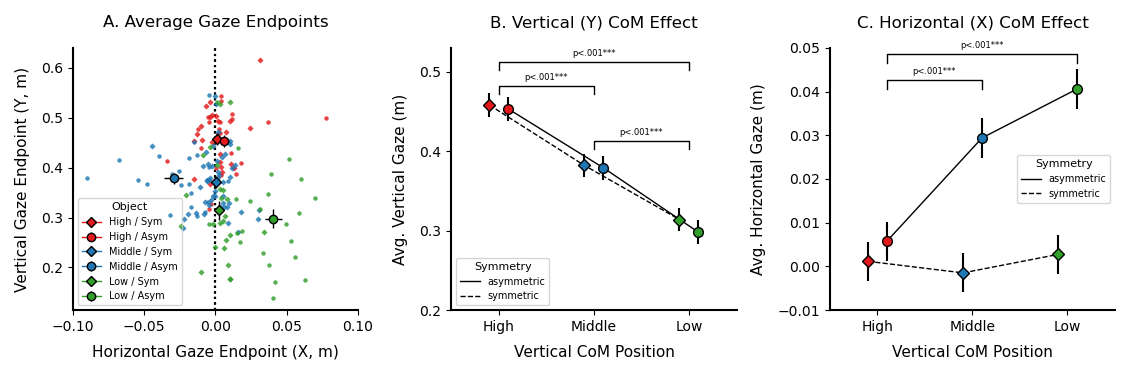

In [32]:
# Figure for FINAL GAZE vectors

emmeans_x_gaze = {'asymmetric': {'mean': [0.00579,  0.02939, 0.04058], 'sem': [0.00447, 0.00454, 0.00447]},
                  'symmetric':  {'mean': [0.00117, -0.00147, 0.00275], 'sem': [0.00447, 0.00447, 0.00447]}}

emmeans_y_gaze = {'asymmetric': {'mean': [0.453, 0.379, 0.298], 'sem': [0.0149, 0.0151, 0.0149]},
                  'symmetric':  {'mean': [0.458, 0.382, 0.314], 'sem': [0.0149, 0.0149, 0.0149]}}

def plot_gaze_emmeans(aggdata, var='efrc3d', xlimits=0.1, ylimits=3.5, emm_x=None, emm_y=None):
    """ Plot X-Y endpoint positions and LMM emmeans for X and Y coordinates """  
    
    SMALL_MARKER_ALPHA = 0.35
    SMALL_MARKER_SIZE = 3
    AVG_MARKER_ALPHA = 1
    AVG_MARKER_SIZE = 5
    LABEL_SIZE = 11
    TITLE_PAD = 15
    MARKER_EDGE_COLOR = 'k'
    MARKER_EDGE_WIDTH = 1.0
    LABEL_PAD = 8

    DODGE = 0.10
    LINESTYLES = {'symmetric': '--', 'asymmetric': '-'}

    COLORS = {'high': [Paired_6.mpl_colors[5], Paired_6.mpl_colors[5]], 
              'middle': [Paired_6.mpl_colors[1], Paired_6.mpl_colors[1]],
              'low': [Paired_6.mpl_colors[3], Paired_6.mpl_colors[3]]}
    
    fig, ax = plt.subplots(1, 3, figsize=(11.3, 3.75), subplot_kw={'facecolor': 'none'})
    d = aggdata.copy()

    # A: 3D Endpoints
    for vx, vv in enumerate(d.loc[:, 'vertical'].unique()):
        
        dv = d.loc[d.vertical == vv, :].copy()  
        scolor = COLORS[vv][0]
        acolor = COLORS[vv][1]
        
        # Midline 
        ax[0].axvline(x=0.0, linestyle=':', color='k', linewidth=1.5, zorder=0)

        # Individual Participants - symmetric
        ax[0].plot(dv.loc[dv.symmetry == 'sym', '{:s}_X'.format(var)], dv.loc[dv.symmetry == 'sym', '{:s}_Y'.format(var)], linewidth=0,
                   marker='D', color=scolor, markersize=SMALL_MARKER_SIZE, alpha=SMALL_MARKER_ALPHA, markeredgewidth=0, markeredgecolor="None")

        # Individual Participants - asymmetric
        ax[0].plot(dv.loc[dv.symmetry == 'asym', '{:s}_X'.format(var)], dv.loc[dv.symmetry == 'asym', '{:s}_Y'.format(var)], linewidth=0,
                   marker='o', color=acolor, markersize=SMALL_MARKER_SIZE, alpha=SMALL_MARKER_ALPHA, markeredgewidth=0, markeredgecolor="None")

        # Average - symmetric
        ax[0].errorbar(x=np.nanmean(dv.loc[dv.symmetry == 'sym', '{:s}_X'.format(var)]), 
                       y=np.nanmean(dv.loc[dv.symmetry == 'sym', '{:s}_Y'.format(var)]),
                       xerr=np.nanstd(dv.loc[dv.symmetry == 'sym', '{:s}_X'.format(var)]) / np.sqrt(24),
                       yerr=np.nanstd(dv.loc[dv.symmetry == 'sym', '{:s}_Y'.format(var)]) / np.sqrt(24),
                       linewidth=MARKER_EDGE_WIDTH, 
                       marker='D', color=scolor, markersize=AVG_MARKER_SIZE, 
                       markeredgecolor=MARKER_EDGE_COLOR, zorder=3, ecolor='k',
                       markeredgewidth=MARKER_EDGE_WIDTH, label='{:s} / Sym'.format(vv.capitalize()))
        
        # Average - asymmetric
        ax[0].errorbar(x=np.nanmean(dv.loc[dv.symmetry == 'asym', '{:s}_X'.format(var)]), 
                       y=np.nanmean(dv.loc[dv.symmetry == 'asym', '{:s}_Y'.format(var)]),
                       xerr=np.nanstd(dv.loc[dv.symmetry == 'asym', '{:s}_X'.format(var)]) / np.sqrt(24),
                       yerr=np.nanstd(dv.loc[dv.symmetry == 'asym', '{:s}_Y'.format(var)]) / np.sqrt(24),
                       linewidth=MARKER_EDGE_WIDTH, 
                       marker='o', color=acolor, markersize=AVG_MARKER_SIZE+1, 
                       markeredgecolor=MARKER_EDGE_COLOR, zorder=3,  ecolor='k',
                       markeredgewidth=MARKER_EDGE_WIDTH, label='{:s} / Asym'.format(vv.capitalize()))

    ax[0].legend(loc='lower left', fontsize=7, facecolor='none', title='Object')
    ax[0].set_title('A. Average Gaze Endpoints', pad=TITLE_PAD)
    ax[0].set_xlim([-xlimits, xlimits])
    ax[0].set_xlabel('Horizontal Gaze Endpoint (X, m)', fontsize=LABEL_SIZE, labelpad=LABEL_PAD)
    ax[0].set_ylabel('Vertical Gaze Endpoint (Y, m)', fontsize=LABEL_SIZE, labelpad=LABEL_PAD)
    
    # B.: Y coordinate LMM
    for symmetry in ['asymmetric', 'symmetric']:
        xs = []
        ys = []
        for cx, cog in enumerate(COG_LABELS):
            if symmetry == 'symmetric':
                x = cx + 1 - DODGE
                emarker = 'D'
                ecolor = COLORS[cog][0]
                ems = AVG_MARKER_SIZE + 1
            else:
                x = cx + 1 + DODGE
                emarker = 'o'
                ecolor = COLORS[cog][1]
                ems = AVG_MARKER_SIZE + 2
                
            ax[1].errorbar(x, emm_y[symmetry]['mean'][cx], 
                           yerr=emm_y[symmetry]['sem'][cx], 
                           marker=emarker, 
                           color=ecolor, 
                           ms=ems, zorder=3, 
                           markeredgecolor=MARKER_EDGE_COLOR,
                           markeredgewidth=MARKER_EDGE_WIDTH,
                           ecolor='k')
            
            xs.append(x)
            ys.append(emm_y[symmetry]['mean'][cx])
        
        # Lines
        h, = ax[1].plot(xs, ys, marker='none', ls=LINESTYLES[symmetry], color='k', 
                        lw=1, label=symmetry)

    ax[1].set_title('B. Vertical (Y) CoM Effect', pad=TITLE_PAD)
    ax[1].set_xlim([0.5, 3.5])
    ax[1].set_xlabel('Vertical CoM Position', fontsize=LABEL_SIZE, labelpad=LABEL_PAD)
    ax[1].set_xticks([1, 2, 3])
    ax[1].set_xticklabels([x.capitalize() for x in COG_LABELS])
    ax[1].set_ylabel('Avg. Vertical Gaze (m)', fontsize=LABEL_SIZE, labelpad=LABEL_PAD)
    ax[1].set_ylim([0.2, 0.53])
    ax[1].set_yticks([0.2, 0.3, 0.4, 0.5])

    #ax[1].set_ylim([-0.03, 0.08])
    #ax[1].set_yticks([-0.3, -0.1, 0.1, 0.3, 0])
    ax[1].legend(title='Symmetry', loc='lower left', fontsize=7)
    
    
    # C.: Y coordinate LMM
    for symmetry in ['asymmetric', 'symmetric']:
        xs = []
        ys = []
        for cx, cog in enumerate(COG_LABELS):
            if symmetry == 'symmetric':
                x = cx + 1 - DODGE
                emarker = 'D'
                ecolor = COLORS[cog][0]
                ems = AVG_MARKER_SIZE + 1
            else:
                x = cx + 1 + DODGE
                emarker = 'o'
                ecolor = COLORS[cog][1]
                ems = AVG_MARKER_SIZE + 2
                
            ax[2].errorbar(x, emm_x[symmetry]['mean'][cx], 
                           yerr=emm_x[symmetry]['sem'][cx], 
                           marker=emarker, 
                           color=ecolor, 
                           ms=ems, zorder=3, 
                           markeredgecolor=MARKER_EDGE_COLOR,
                           markeredgewidth=MARKER_EDGE_WIDTH,
                           ecolor='k')
            xs.append(x)
            ys.append(emm_x[symmetry]['mean'][cx])
        
        # Lines
        h, = ax[2].plot(xs, ys, marker='none', ls=LINESTYLES[symmetry], color='k', 
                        lw=1, label=symmetry)
        
    ax[2].set_title('C. Horizontal (X) CoM Effect', pad=TITLE_PAD)
    ax[2].set_xlim([0.5, 3.5])
    ax[2].set_xlabel('Vertical CoM Position', fontsize=LABEL_SIZE, labelpad=LABEL_PAD)
    ax[2].set_xticks([1, 2, 3])
    ax[2].set_xticklabels([x.capitalize() for x in COG_LABELS])
    ax[2].set_ylabel('Avg. Horizontal Gaze (m)', fontsize=LABEL_SIZE, labelpad=LABEL_PAD)    
    ax[2].legend(title='Symmetry', fontsize=7)
    ax[2].set_ylim([-0.01, 0.005])
    ax[2].set_yticks([-0.01, 0, 0.01, 0.02, 0.03, 0.04, 0.05])

    plt.setp(ax[0].get_legend().get_title(), fontsize=8)
    plt.setp(ax[1].get_legend().get_title(), fontsize=8)
    plt.setp(ax[2].get_legend().get_title(), fontsize=8)
    
    # Vertical
    annotate_comparison(ax[1], 1, 3, 0.52, "p<.001***", linewidth=1.0, fontsize=6, height=0.01, color='k')
    annotate_comparison(ax[1], 1, 2, 0.49, "p<.001***", linewidth=1.0, fontsize=6, height=0.01, color='k')
    annotate_comparison(ax[1], 2, 3, 0.42, "p<.001***", linewidth=1.0, fontsize=6, height=0.01, color='k')    

    # Horizontal
    annotate_comparison(ax[2], 1 + DODGE, 3 + DODGE, 0.05, "p<.001***", linewidth=1.0, fontsize=6, height=0.002, color='k')
    annotate_comparison(ax[2], 1 + DODGE, 2 + DODGE, 0.044, "p<.001***", linewidth=1.0, fontsize=6, height=0.002, color='k')
    
    # General Formatting
    for axx in ax:
        for axis in ['bottom','left']:
            axx.spines[axis].set_linewidth(1.5)
        for axis in ['top','right']:
            axx.spines[axis].set_linewidth(0)

    
    plt.tight_layout()
    
plot_gaze_emmeans(avgdata, var='final_gaze3d', xlimits=0.1, emm_x=emmeans_x_gaze, emm_y=emmeans_y_gaze)
plt.savefig(os.path.join(FOLDER_FIG, 'cog_manipulation_gaze.png'), dpi=300)
plt.savefig(os.path.join(FOLDER_FIG, 'cog_manipulation_gaze.pdf'), dpi=300)